# 🧪 01 - Simulated Forecasting using Bayesian LSTM

In this notebook, we generate a noisy sine wave and use our Bayesian LSTM to forecast with uncertainty estimates using MC Dropout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from bayeslstm import BayesianLSTM, vectorized_mc_dropout_predict

# Generate sine wave + noise
def generate_data(seq_len=30, num_samples=300):
    X, y = [], []
    for _ in range(num_samples):
        start = np.random.uniform(0, 2*np.pi)
        t = np.linspace(start, start + np.pi, seq_len+1)
        signal = np.sin(t) + np.random.normal(0, 0.1, size=seq_len+1)
        X.append(signal[:-1])
        y.append(signal[-1])
    return np.array(X), np.array(y)

X, y = generate_data()
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)


In [2]:
# Split into train and test
train_X, test_X = X_tensor[:250], X_tensor[250:]
train_y, test_y = y_tensor[:250], y_tensor[250:]


In [3]:
# Train model
model = BayesianLSTM(input_size=1, hidden_size=32, output_size=1, dropout_rate=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

model.train()
for epoch in range(20):
    idx = torch.randperm(train_X.shape[0])
    for i in range(0, len(train_X), 32):
        xb = train_X[idx[i:i+32]]
        yb = train_y[idx[i:i+32]]
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()


In [4]:
# Predict with MC Dropout
model.eval()
mean_preds, std_preds = vectorized_mc_dropout_predict(model, test_X, T=100)
true_y = test_y.squeeze().numpy()


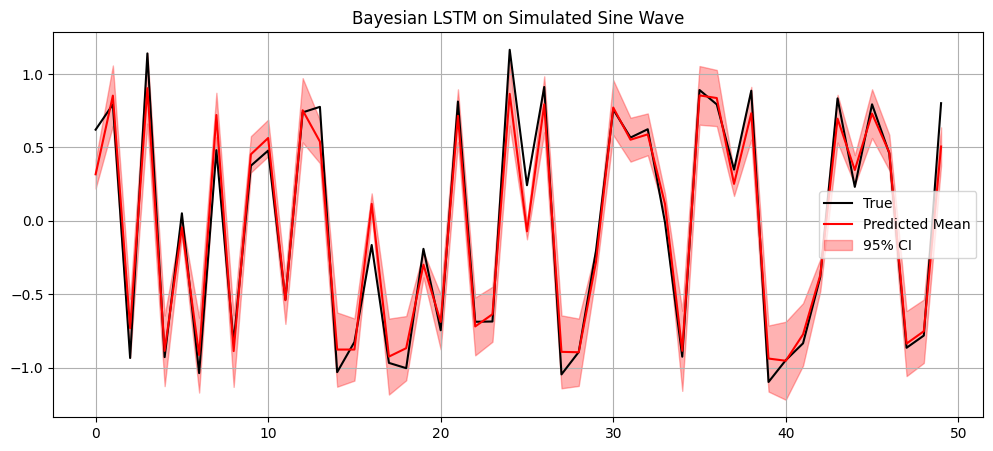

In [5]:
# Plot predictions with uncertainty
plt.figure(figsize=(12, 5))
plt.plot(true_y, label="True", color="black")
plt.plot(mean_preds, label="Predicted Mean", color="red")
plt.fill_between(np.arange(len(std_preds)),
                 mean_preds[:,0] - 2*std_preds[:,0],
                 mean_preds[:,0] + 2*std_preds[:,0],
                 alpha=0.3, color='red', label='95% CI')
plt.title("Bayesian LSTM on Simulated Sine Wave")
plt.legend()
plt.grid(True)
plt.show()
